In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences

import sys
sys.path.append('../')

from src.attention import SelfAttention
#from src.models import FBRNN
torch.manual_seed(1)

DATA_DIR = '../Data/'

Using TensorFlow backend.


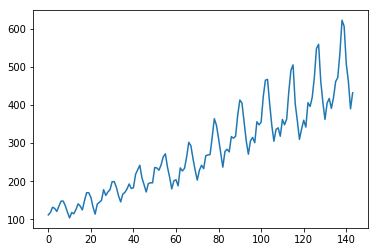

In [2]:
dataset = pd.read_csv(DATA_DIR+'international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [3]:
batch_size = 1

sample_batch = torch.t(torch.tensor(dataset.values)).long()
print(sample_batch.type())

torch.LongTensor


In [4]:
num_embeddings = 1000
embedding_dim = 5
embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
embedding

Embedding(1000, 5)

In [5]:
embedded_input = embedding(sample_batch).view(144,1,5)
embedded_input.shape # (sequence, batch, token)

torch.Size([144, 1, 5])

In [6]:
hidden_size = 16
layer_a_cell = nn.GRUCell(input_size=embedding_dim, hidden_size=hidden_size)
layer_b_cell = nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size)

In [7]:
tok_1 = embedded_input[0, :, :]
tok_2 = embedded_input[1, :, :]

In [8]:
ha_0 = torch.zeros((batch_size, hidden_size))
hb_0 = torch.zeros((batch_size, hidden_size))
print(ha_0.shape)
ha = layer_a_cell(tok_1, ha_0)
hb = layer_b_cell(ha, hb_0)

torch.Size([1, 16])


In [9]:
torch.cat([ha, hb], dim=1).shape

torch.Size([1, 32])

In [10]:
#ha_new = ha + hb
#composition = nn.Linear(2 * hidden_size, hidden_size); ha_new = composition(torch.cat([ha, hb], dim=1))
att_hidden_size=10
ha_attention = SelfAttention(input_vector_size=hidden_size, hidden_size=att_hidden_size)
ha_new = ha_attention.combine(torch.stack([ha, hb]))
ha = layer_a_cell(tok_2, ha_new)
hb = layer_b_cell(ha, hb)

In [75]:
class FBRNN(nn.Module):

    def __init__(self, embedding_dim, vocab_size, hidden_size, num_layers, attention_hidden_size):
        super(FBRNN, self).__init__()
        # HyperParameters
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention_hidden_size = attention_hidden_size

        # Parameters
        self.embedding = nn.Embedding(embedding_dim=embedding_dim, num_embeddings=vocab_size)
        self.cells = nn.ModuleList([nn.GRUCell(input_size=embedding_dim, hidden_size=hidden_size)] +
                                   [nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size) for i in range(num_layers-1)])
        self.hidden_attentions = nn.ModuleList([SelfAttention(input_vector_size=hidden_size, hidden_size=attention_hidden_size) for i in range(num_layers)])
        self.fc = nn.Linear(16,1)
        
    def forward(self, batch):
        embedded_input = self.embedding(batch)
        batch_size = batch.shape[1]
        h_s = [torch.zeros((batch_size, self.hidden_size)) for i in range(self.num_layers)]
        
        out_vecs = []
        for token in embedded_input.split(1):
            input_vec = token.squeeze().view(1,self.embedding_dim)
            # get all outputs (go up)
            new_h_s = []
            for h, cell in zip(h_s, self.cells):
                print('input')
                print(h.shape)
                print(input_vec.shape)
                input_vec = cell(input_vec, h)
                print(input_vec.shape)
                new_h_s.append(input_vec)

            h_s = []
            # compute new hidden states using attention (go right)
            for i, att in enumerate(self.hidden_attentions):
                h_s.append(att.combine(torch.stack(new_h_s[i:])))
            
            output = self.fc(h_s[-1].squeeze())
            out_vecs.append(output.data)
        return out_vecs

In [72]:
class FBRNN(nn.Module):

    def __init__(self, embedding_dim, vocab_size, hidden_size, num_layers, attention_hidden_size):
        super(FBRNN, self).__init__()
        # HyperParameters
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention_hidden_size = attention_hidden_size

        # Parameters
        #self.embedding = nn.Embedding(embedding_dim=embedding_dim, num_embeddings=vocab_size)
        self.cells = nn.ModuleList([nn.GRUCell(input_size=embedding_dim, hidden_size=hidden_size)] +
                                   [nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size) for i in range(num_layers-1)])
        self.hidden_attentions = nn.ModuleList([SelfAttention(input_vector_size=hidden_size, hidden_size=attention_hidden_size) for i in range(num_layers)])
        self.fc = nn.Linear(16,1)
        
    def forward(self, batch):
        #embedded_input = self.embedding(batch)
        batch_size = batch.shape[1]
        h_s = [torch.zeros((batch_size, self.hidden_size)) for i in range(self.num_layers)]
        
        out_vecs = []
        for token in batch.split(1):
            input_vec = token.squeeze().view(1,self.embedding_dim)
            print(input_vec.shape)
            # get all outputs (go up)
            new_h_s = []
            for h, cell in zip(h_s, self.cells):
                print(h.shape)
                input_vec = cell(input_vec, h)
                print(input_vec.shape)
                new_h_s.append(input_vec)

            h_s = []
            # compute new hidden states using attention (go right)
            for i, att in enumerate(self.hidden_attentions):
                h_s.append(att.combine(torch.stack(new_h_s[i:])))
            
            output = self.fc(h_s[-1].squeeze())
            out_vecs.append(output.data)
        return out_vecs

In [76]:
model = FBRNN(embedding_dim=1, vocab_size=1000, hidden_size=hidden_size, num_layers=8, attention_hidden_size=att_hidden_size)

In [77]:
print(sample_batch.shape)
sample_batch = sample_batch.view(144,1,1)
model(sample_batch)[0].shape

torch.Size([144, 1, 1])
input
torch.Size([1, 16])
torch.Size([1, 1])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 1])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Size([1, 16])
input
torch.Size([1, 16])
torch.Size([1, 16])
torch.Si

torch.Size([1])

In [56]:
x = sample_batch[:-1]
y = sample_batch[1:]
print(y.shape)

opt = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

for epoch in range(1000):
    #for batch in train_generator:
    model.zero_grad()
    outputs = model(sample_batch)
    outputs = torch.tensor(outputs[:-1]).view(143,1,1)
    loss = Variable(F.mse_loss(outputs, y.type(torch.float32)),requires_grad=True)
    loss.backward()
    opt.step()

torch.Size([143, 1, 1])


KeyboardInterrupt: 

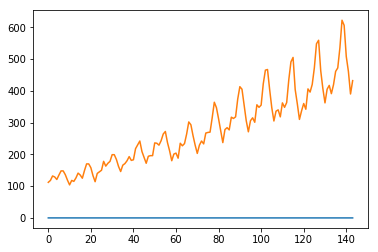

In [53]:
y = model(sample_batch)
plt.plot(np.array(y))
plt.plot(np.array(sample_batch).squeeze())
plt.show()